In [1]:
import requests
import time
import pandas as pd
import spacy
import matplotlib.pyplot as plt
import re
import string
import seaborn as sns
import numpy as np
from bs4 import BeautifulSoup
from tqdm import tqdm
from wordcloud import WordCloud
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

In [7]:
df = pd.read_csv("QueryResults.csv")

C:\Users\12902\AppData\Local\Temp\ipykernel_30572\1492975149.py:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




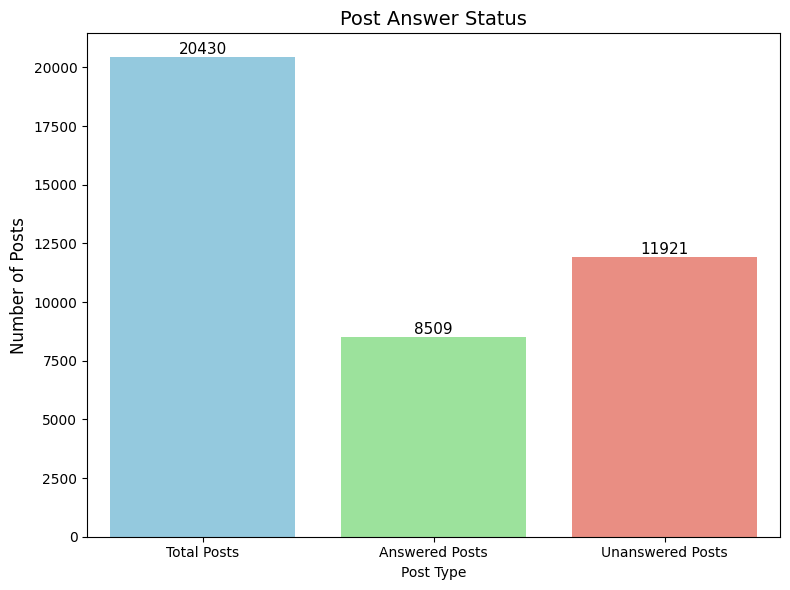

In [34]:
df["HasAnswer"] = df["AcceptedAnswerBody"].apply(lambda x: 0 if pd.isna(x) or str(x).strip() == "" else 1)
total_posts = len(df)
answered_posts = df["HasAnswer"].sum()
unanswered_posts = total_posts - answered_posts

post_stats = pd.DataFrame({
    "Post Type": ["Total Posts", "Answered Posts", "Unanswered Posts"],
    "Count": [total_posts, answered_posts, unanswered_posts]
})

plt.figure(figsize=(8, 6))
sns.barplot(data=post_stats, x="Post Type", y="Count", palette=["skyblue", "lightgreen", "salmon"])
plt.title("Post Answer Status", fontsize=14)
plt.ylabel("Number of Posts", fontsize=12)

for i, row in post_stats.iterrows():
    plt.text(i, row["Count"] + 20, int(row["Count"]), ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.show()

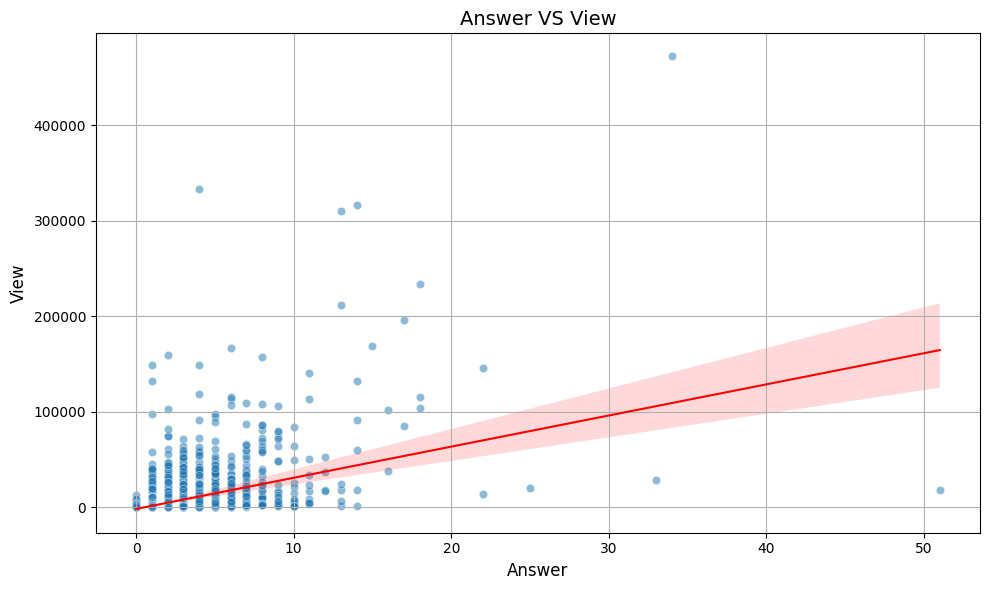

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="AnswerCount", y="ViewCount", alpha=0.5)
sns.regplot(data=df, x="AnswerCount", y="ViewCount", scatter=False, color="red", line_kws={"linewidth":1.5})
plt.title("Answer VS View", fontsize=14)
plt.xlabel("Answer", fontsize=12)
plt.ylabel("View", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])
stopwords = nlp.Defaults.stop_words

def preprocess_text_spacy(text):
    if not isinstance(text, str):
        return ""

    soup = BeautifulSoup(text, "html.parser") # HTML and images
    for img in soup.find_all("img"):
        img.decompose()
    text = soup.get_text()

    text = re.sub(f"[{re.escape(string.punctuation)}]", " ", text) # punctuation 
    text = text.lower() # lowercase
    text = re.sub(r"\s+", " ", text).strip() # whitespace
    
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct and token.is_alpha] # stopwords and lemmatize

    return " ".join(tokens)

tqdm.pandas(desc="Preprocessing title") # tqdm progress
df["title_clean"] = df["Title"].progress_apply(preprocess_text_spacy)
tqdm.pandas(desc="Preprocessing body")
df["body_clean"] = df["Body"].progress_apply(preprocess_text_spacy)
tqdm.pandas(desc="Preprocessing acceptedanswerbody")
df["accepted_answer_clean"] = df["AcceptedAnswerBody"].progress_apply(preprocess_text_spacy)
df.to_csv("cleaned_data.csv", index=False) # save data

Preprocessing title:  47%|████▋     | 9542/20430 [00:33<00:34, 312.07it/s]C:\Users\12902\AppData\Local\Temp\ipykernel_23004\3806605151.py:8: MarkupResemblesLocatorWarning: The input passed in on this line looks more like a filename than HTML or XML.

If you meant to use Beautiful Soup to parse the contents of a file on disk, then something has gone wrong. You should open the file first, using code like this:

    filehandle = open(your filename)

You can then feed the open filehandle into Beautiful Soup instead of using the filename.

However, if you want to parse some data that happens to look like a filename, then nothing has gone wrong: you are using Beautiful Soup correctly, and this warning is spurious and can be filtered. To make this warning go away, run this code before calling the BeautifulSoup constructor:

    from bs4 import MarkupResemblesLocatorWarning
    import warnings

    warnings.filterwarnings("ignore", category=MarkupResemblesLocatorWarning)
    
  soup = Beautifu

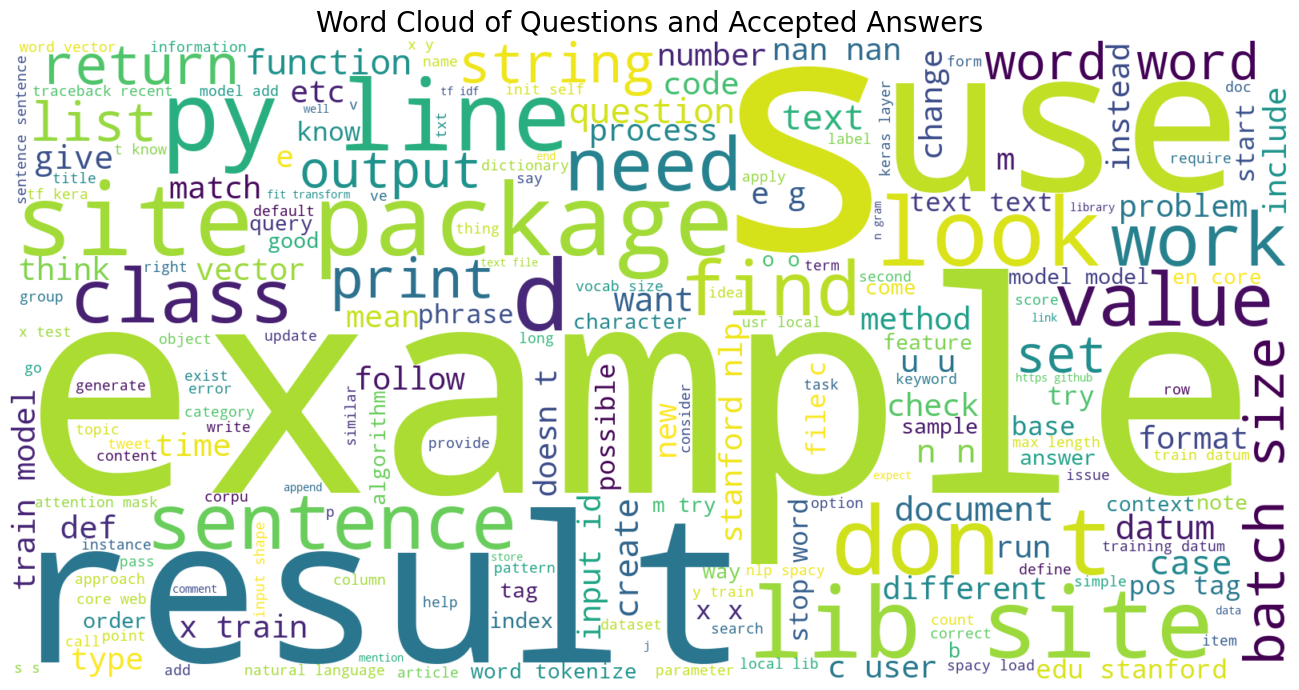

In [9]:
all_text = " ".join(df["body_clean"].fillna("") + " " + df["accepted_answer_clean"].fillna("")) # Combine all text
wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(all_text)

plt.figure(figsize=(14, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Questions and Accepted Answers", fontsize=20)
plt.tight_layout()
plt.show()

C:\Users\12902\AppData\Local\Temp\ipykernel_30572\1577167360.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Frequency", y="Word", data=top_df, palette="viridis")


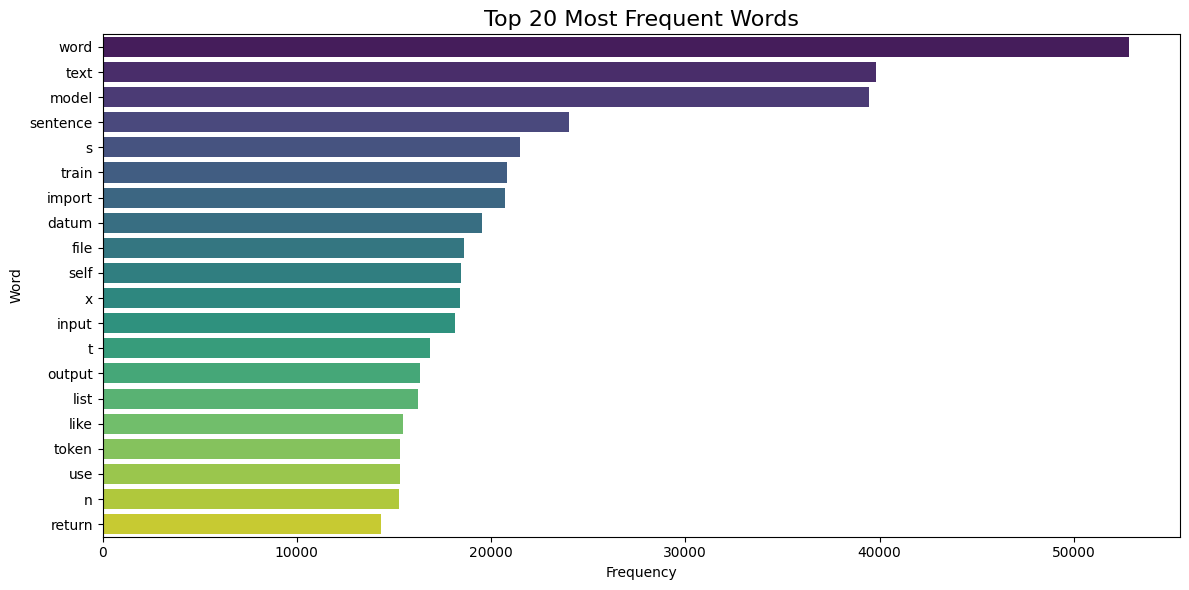

In [10]:
tokens = all_text.split() # Tokenize
counter = Counter(tokens) # count
top_words = counter.most_common(20)
top_df = pd.DataFrame(top_words, columns=["Word", "Frequency"])

plt.figure(figsize=(12, 6))
sns.barplot(x="Frequency", y="Word", data=top_df, palette="viridis")
plt.title("Top 20 Most Frequent Words", fontsize=16)
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.tight_layout()
plt.show()

C:\Users\12902\AppData\Local\Temp\ipykernel_30572\1105094406.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Frequency", y="N-gram", data=bigram_df, palette="Blues_d")


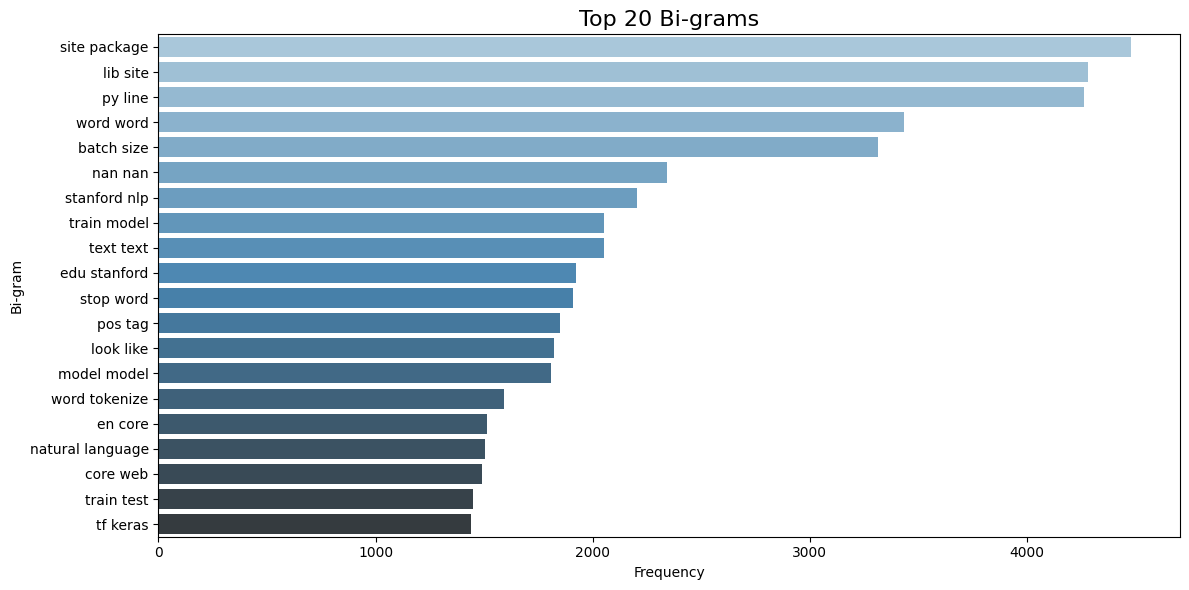

C:\Users\12902\AppData\Local\Temp\ipykernel_30572\1105094406.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Frequency", y="N-gram", data=trigram_df, palette="Greens_d")


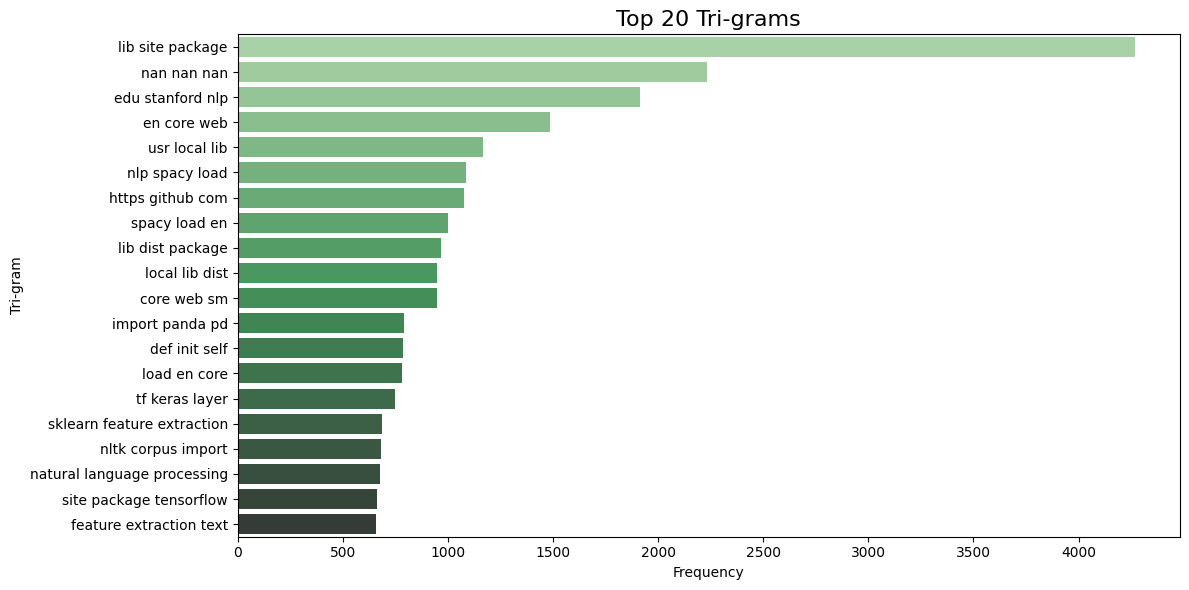

In [ ]:
def get_top_ngrams(corpus, ngram_range=(2, 2), top_k=20):
    vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words='english')
    X = vectorizer.fit_transform([corpus])
    sum_words = X.sum(axis=0)
    ngram_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    ngram_freq = sorted(ngram_freq, key=lambda x: x[1], reverse=True)[:top_k]
    return pd.DataFrame(ngram_freq, columns=["N-gram", "Frequency"])

bigram_df = get_top_ngrams(all_text, (2, 2))
plt.figure(figsize=(12, 6))
sns.barplot(x="Frequency", y="N-gram", data=bigram_df, palette="Blues_d")
plt.title("Top 20 Bi-grams", fontsize=16)
plt.xlabel("Frequency")
plt.ylabel("Bi-gram")
plt.tight_layout()
plt.show()

trigram_df = get_top_ngrams(all_text, (3, 3))
plt.figure(figsize=(12, 6))
sns.barplot(x="Frequency", y="N-gram", data=trigram_df, palette="Greens_d")
plt.title("Top 20 Tri-grams", fontsize=16)
plt.xlabel("Frequency")
plt.ylabel("Tri-gram")
plt.tight_layout()
plt.show()


In [12]:
task_keywords = {
    'nlp': ['natural language process', 'nlp'],
    'bert-language-model': ['bert', 'language model'],
    'transformer': ['transformer', 'attention mechanism'],
    'spacy': ['spacy'],
    'nltk': ['nltk'],
    'word2vec': ['word2vec'],
    'gensim': ['gensim'],
    'fasttext': ['fasttext'],
    'lda': ['lda', 'latent dirichlet'],
    'text-classification': ['text classification', 'classify text', 'document classification'],
    'sentiment-analysis': ['sentiment', 'opinion', 'emotion', 'polarity'],
    'lemmatization': ['lemmatize', 'lemmatization', 'lemmatizer'],
    'tf-idf': ['tfidf', 'term frequency', 'inverse document frequency']
}

def classify_task(text):
    matched_tags = []
    for tag, keywords in task_keywords.items():
        for kw in keywords:
            if re.search(r'\b' + re.escape(kw) + r'\b', text, flags=re.IGNORECASE):
                matched_tags.append(tag)
                break
    return ", ".join(matched_tags)

df["combined_text"] = df["Title"] + " " + df["Body"]
df["task_category"] = df["combined_text"].apply(classify_task)
print(df["task_category"].value_counts())

task_category
                                            9269
nlp                                         2688
nltk                                        1512
nlp, spacy                                   965
bert-language-model                          695
                                            ... 
bert-language-model, tf-idf                    1
nlp, nltk, gensim, lemmatization, tf-idf       1
bert-language-model, word2vec, tf-idf          1
nlp, bert-language-model, gensim               1
transformer, nltk, tf-idf                      1
Name: count, Length: 290, dtype: int64


In [ ]:
X = df["combined_text"]
y_raw = df["task_category"].apply(lambda x: x.split(", ") if x else [])
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y_raw)

tfidf = TfidfVectorizer(max_features=5000) # TF-IDF
X_tfidf = tfidf.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)
clf = OneVsRestClassifier(LogisticRegression(max_iter=1000))

cv_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='f1_micro') # cross valid
print("Cross-Validation F1-micro scores:", cv_scores)
print("Average CV F1-micro score:", np.mean(cv_scores))

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("\nTest set classification report:\n")
print(classification_report(y_test, y_pred, target_names=mlb.classes_))

Cross-Validation F1-micro scores: [0.72418043 0.72676908 0.73117182 0.71083744 0.72515803]
Average CV F1-micro score: 0.723623357217819

Test set classification report:

                     precision    recall  f1-score   support

bert-language-model       1.00      0.51      0.68       229
           fasttext       1.00      0.48      0.65        27
             gensim       1.00      0.63      0.77       171
                lda       1.00      0.46      0.63        57
      lemmatization       1.00      0.28      0.43       101
                nlp       1.00      0.68      0.81      1022
               nltk       1.00      0.66      0.80       489
 sentiment-analysis       1.00      0.48      0.64       221
              spacy       1.00      0.72      0.84       376
text-classification       0.84      0.14      0.23       118
             tf-idf       1.00      0.34      0.51        87
        transformer       1.00      0.20      0.33        91
           word2vec       1.00      

C:\Users\12902\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\12902\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\12902\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:15

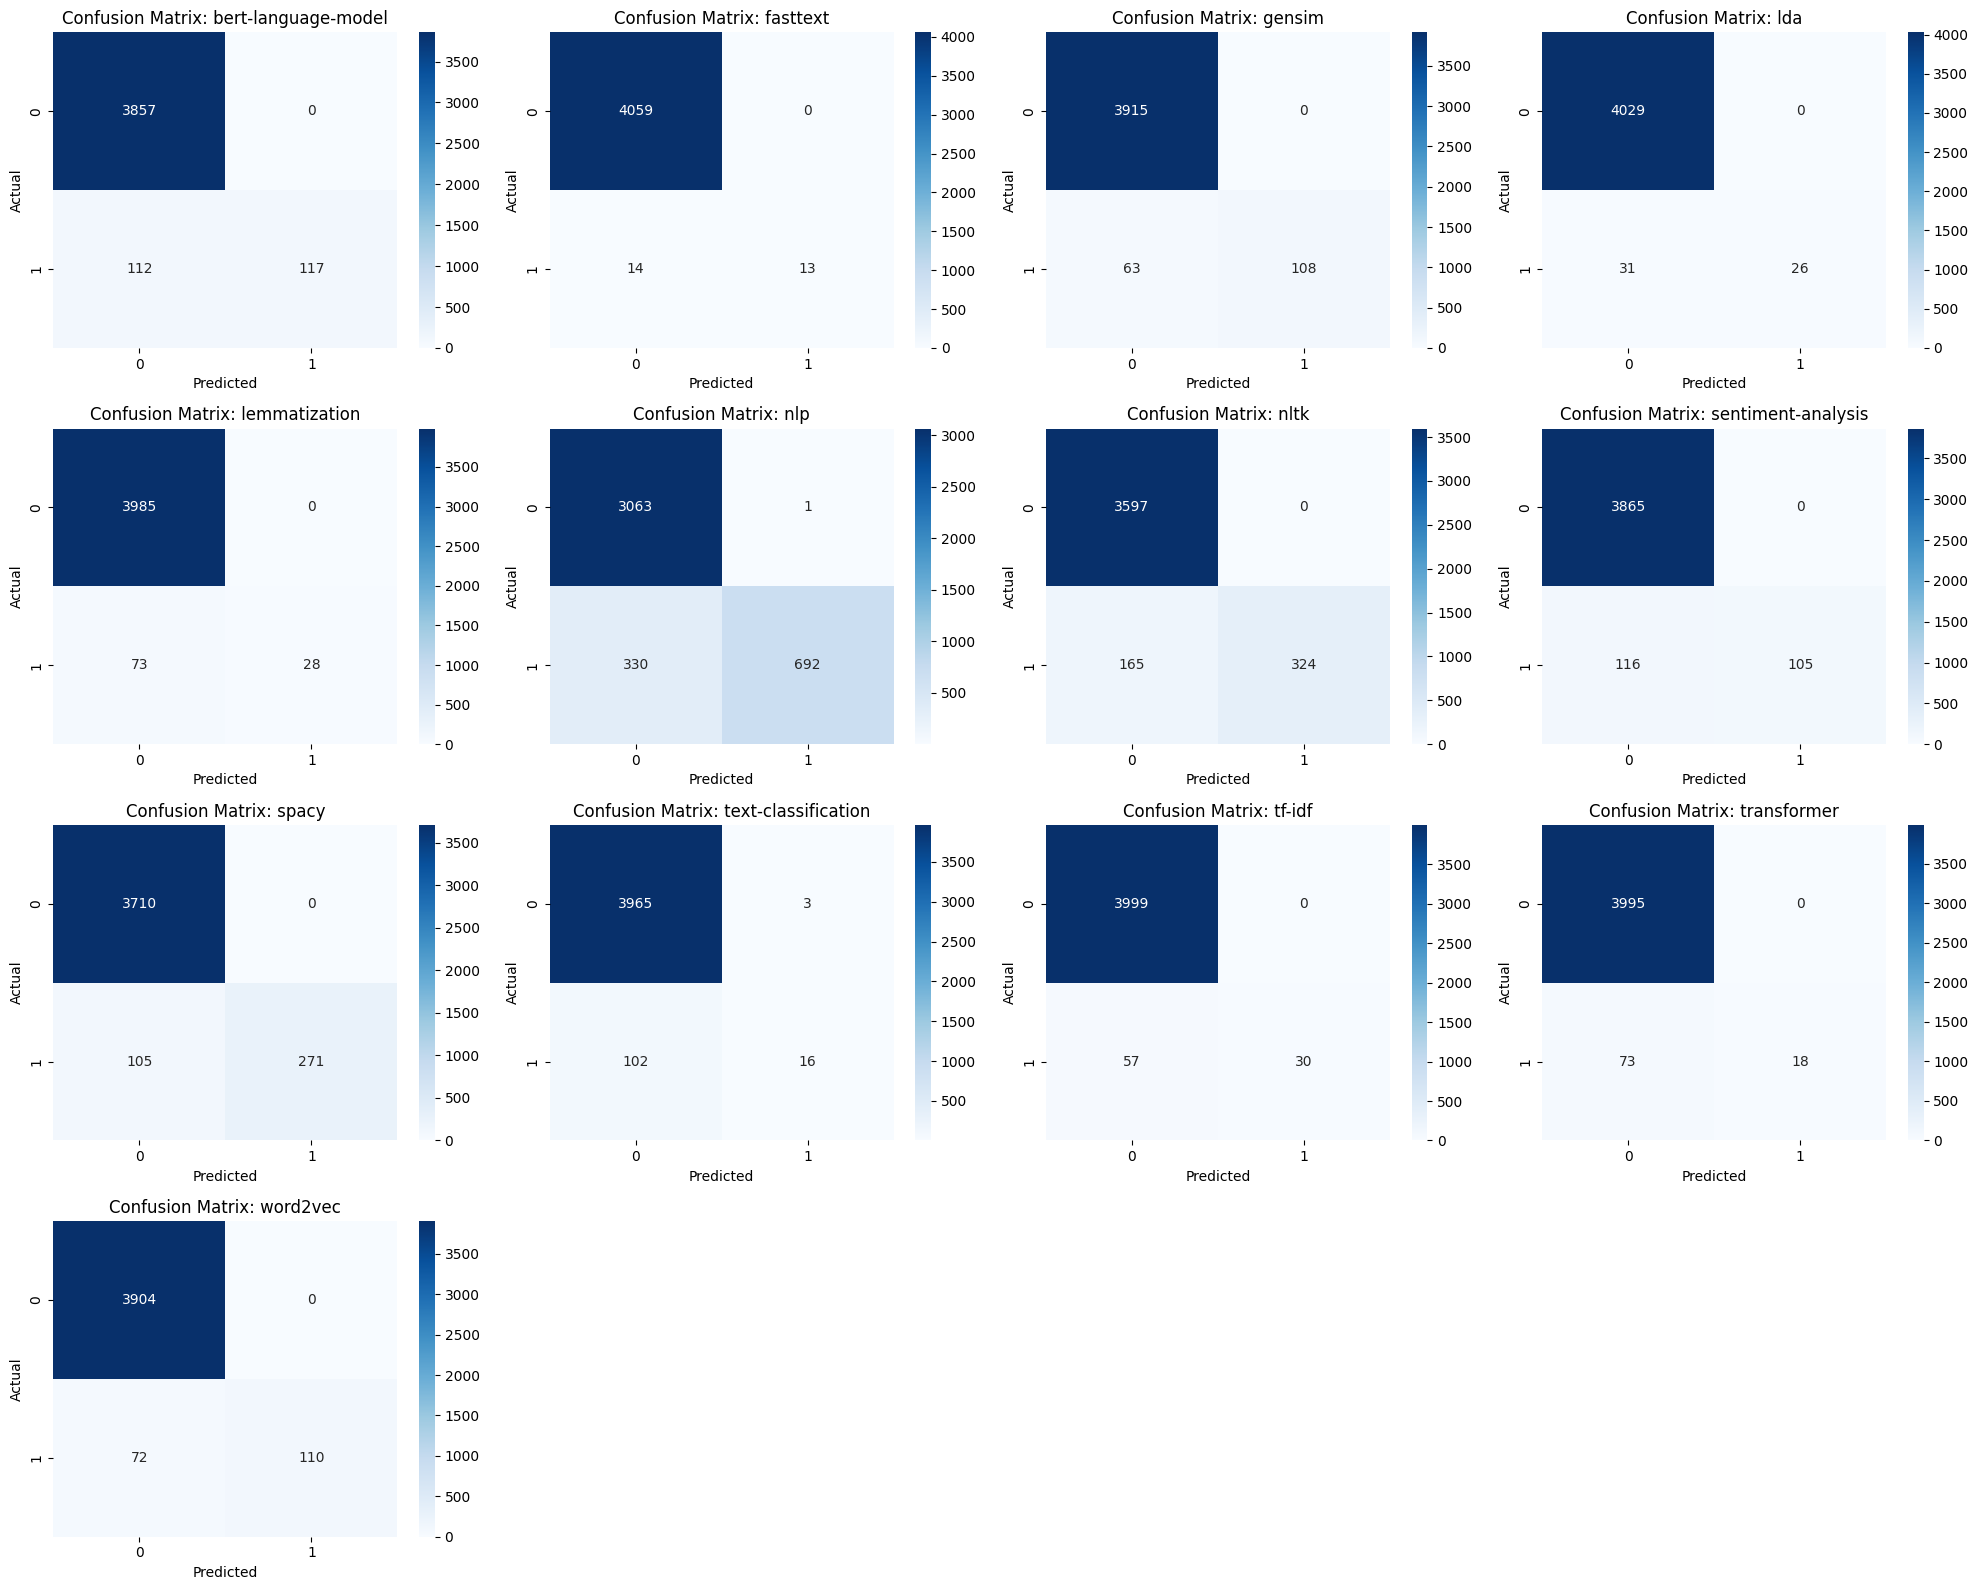

In [ ]:
y_true = y_test
labels = mlb.classes_
conf_matrices = multilabel_confusion_matrix(y_true, y_pred)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 16))
axes = axes.flatten()

for i, (cm, label) in enumerate(zip(conf_matrices, labels)):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f"Confusion Matrix: {label}")
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("Actual")

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()